<a href="https://colab.research.google.com/github/Marcellinus08/Deep-Learning/blob/main/LSTM%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WEEK 6

## GRU Models

### Tensorflow

Persiapan Data

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import json
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Load dataset
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json"
df = pd.read_json(url, lines=True)


import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = text.strip()
    return text

df['headline'] = df['headline'].apply(clean_text)


In [4]:
# Label encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['is_sarcastic'])


In [5]:
# Tokenisasi dan padding
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['headline'])
sequences = tokenizer.texts_to_sequences(df['headline'])

max_len = 100
padded = pad_sequences(sequences, maxlen=max_len, padding='post')

X = np.array(padded)
y = np.array(df['label'])

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vocab_size = len(tokenizer.word_index) + 1

Build Model LSTM (TensorFlow)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=3,                    # lebih banyak epoch
    batch_size=64,                # batch lebih besar
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/3
334/334 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.6099 - loss: 0.6350 - val_accuracy: 0.8355 - val_loss: 0.3851
Epoch 2/3
334/334 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.8847 - loss: 0.2998 - val_accuracy: 0.8531 - val_loss: 0.3533
Epoch 3/3
334/334 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.9372 - loss: 0.1879 - val_accuracy: 0.8555 - val_loss: 0.3715


Evaluasi: Akurasi, Presisi, Recall, F1 Squared, AUC, ROC

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Prediksi
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrik
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_squared = f1_score(y_test, y_pred, average='binary') ** 2
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Akurasi: {accuracy:.4f}")
print(f"Presisi: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_squared:.4f}")
print(f"AUC: {auc:.4f}")


167/167 ━━━━━━━━━━━━━━━━━━━━ 36s 200ms/step
Akurasi: 0.8555
Presisi: 0.8407
Recall: 0.8278
F1 Squared: 0.6959
AUC: 0.9309


Visualisasi Akurasi dan Loss

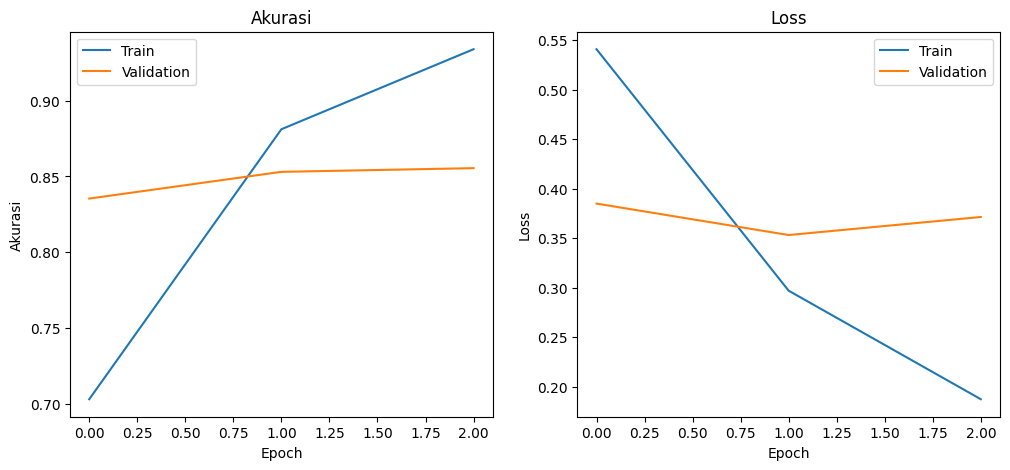

In [10]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [11]:
!pip install -q keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [12]:
import keras_tuner as kt
from tensorflow import keras

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim=vocab_size,
                                     output_dim=hp.Int('embed_dim', 64, 256, step=64),
                                     input_length=max_len))

    model.add(keras.layers.Bidirectional(keras.layers.LSTM(
        hp.Int('lstm_units', 32, 128, step=32),
        return_sequences=True
    )))
    model.add(keras.layers.Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(keras.layers.Bidirectional(keras.layers.LSTM(
        hp.Int('lstm_units_2', 32, 64, step=16)
    )))
    model.add(keras.layers.Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'))
    model.add(keras.layers.Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [13]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_lstm',
    project_name='sarcasm_lstm'
)

tuner.search_space_summary()

# Mulai tuning
tuner.search(X_train, y_train,
             epochs=5,
             batch_size=64,
             validation_data=(X_test, y_test),
             verbose=1)


Trial 5 Complete [00h 26m 26s]
val_accuracy: 0.8523024916648865

Best val_accuracy So Far: 0.8648446202278137
Total elapsed time: 01h 41m 43s


In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/3
334/334 ━━━━━━━━━━━━━━━━━━━━ 149s 421ms/step - accuracy: 0.7379 - loss: 0.4931 - val_accuracy: 0.8600 - val_loss: 0.3234
Epoch 2/3
334/334 ━━━━━━━━━━━━━━━━━━━━ 140s 420ms/step - accuracy: 0.9445 - loss: 0.1523 - val_accuracy: 0.8585 - val_loss: 0.3516
Epoch 3/3
334/334 ━━━━━━━━━━━━━━━━━━━━ 138s 408ms/step - accuracy: 0.9833 - loss: 0.0538 - val_accuracy: 0.8534 - val_loss: 0.4929


167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2996
           1       0.84      0.82      0.83      2346

    accuracy                           0.85      5342
   macro avg       0.85      0.85      0.85      5342
weighted avg       0.85      0.85      0.85      5342

167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step
AUC: 0.9283


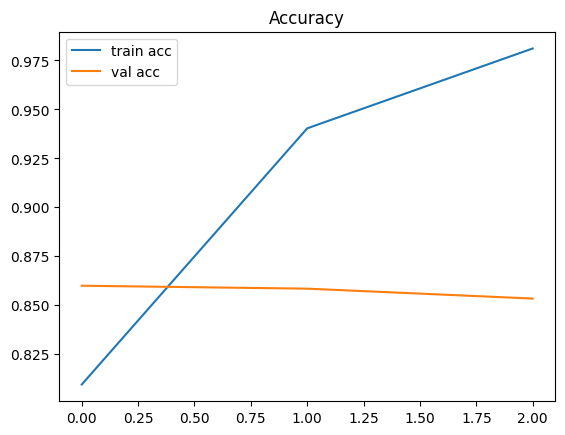

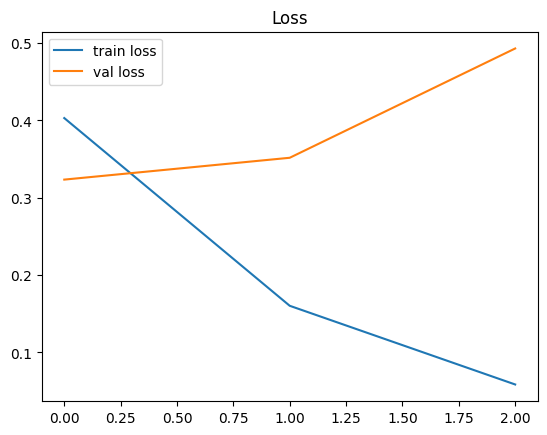

In [15]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Prediksi
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Metrik
print(classification_report(y_test, y_pred))

# ROC-AUC
probs = model.predict(X_test)
auc = roc_auc_score(y_test, probs)
print(f"AUC: {auc:.4f}")

# Visualisasi Akurasi dan Loss
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss")
plt.show()


### Pytorch

Import dan Setup

In [18]:
!pip install torch torchvision torchaudio scikit-learn matplotlib nltk

# Import Library
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import string
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from nltk.corpus import stopwords
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load & Processing Data

In [19]:
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json"
df = pd.read_json(url, lines=True)

# Preprocessing function
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URL
    text = re.sub(r'\@w+|\#','', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

df['tokens'] = df['headline'].apply(clean_text)

Encode

In [20]:
all_words = [word for tokens in df['tokens'] for word in tokens]
vocab = Counter(all_words)
vocab = {word: i+2 for i, (word, _) in enumerate(vocab.items())}  # +2 untuk padding dan unknown
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# Encode token
def encode_tokens(tokens, vocab):
    return [vocab.get(word, vocab['<UNK>']) for word in tokens]

df['encoded'] = df['tokens'].apply(lambda x: encode_tokens(x, vocab))

Dataset

In [21]:
MAX_LEN = 25
class SarcasmDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = [torch.tensor(x[:MAX_LEN] + [0]*(MAX_LEN - len(x))) for x in encodings]
        self.labels = labels

    def __getitem__(self, idx):
        return self.encodings[idx], self.labels[idx]

    def __len__(self):
        return len(self.labels)

X_train, X_test, y_train, y_test = train_test_split(df['encoded'], df['is_sarcastic'], test_size=0.2, random_state=42)

train_dataset = SarcasmDataset(X_train.tolist(), y_train.tolist())
test_dataset = SarcasmDataset(X_test.tolist(), y_test.tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Model LSTM

In [22]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.fc(hidden[-1])
        return self.sigmoid(out)

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(vocab_size=len(vocab), embedding_dim=100, hidden_dim=128, output_dim=1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train model & validation

In [23]:
train_losses, test_losses, train_accs, test_accs = [], [], [], []
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (outputs > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(train_acc)

    # Validation
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = (outputs > 0.5).int()
            correct += (preds == labels.int()).sum().item()
            total += labels.size(0)

        test_acc = correct / total
        test_losses.append(running_loss / len(test_loader))
        test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/10 - Train Acc: 0.5792, Test Acc: 0.5928
Epoch 2/10 - Train Acc: 0.5752, Test Acc: 0.5687
Epoch 3/10 - Train Acc: 0.5759, Test Acc: 0.5608
Epoch 4/10 - Train Acc: 0.5714, Test Acc: 0.5640
Epoch 5/10 - Train Acc: 0.5858, Test Acc: 0.5736
Epoch 6/10 - Train Acc: 0.5775, Test Acc: 0.5608
Epoch 7/10 - Train Acc: 0.5566, Test Acc: 0.5419
Epoch 8/10 - Train Acc: 0.5642, Test Acc: 0.5608
Epoch 9/10 - Train Acc: 0.5620, Test Acc: 0.5608
Epoch 10/10 - Train Acc: 0.5552, Test Acc: 0.5352


Evaluasi

In [25]:
y_true, y_pred, y_score = [], [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze().cpu()
        y_score.extend(outputs.tolist())
        y_pred.extend((outputs > 0.5).int().tolist())
        y_true.extend(labels.tolist())

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("AUC:", roc_auc_score(y_true, y_score))

Accuracy: 0.5351928116810184
Precision: 0.4841910916224325
Recall: 0.8942881500426257
F1 Score: 0.6282377601437341
AUC: 0.5362016505098586


ROC Curve

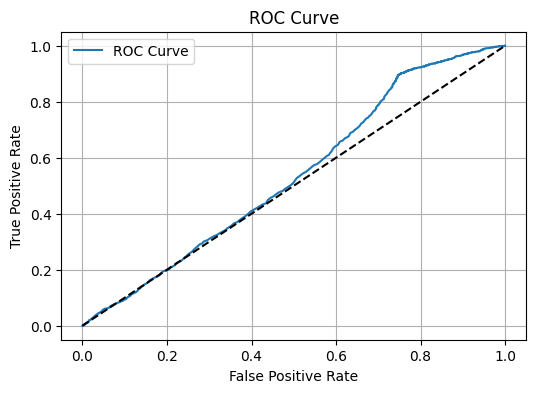

In [26]:
fpr, tpr, _ = roc_curve(y_true, y_score)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

Visualisasi Akurasi dan Loss

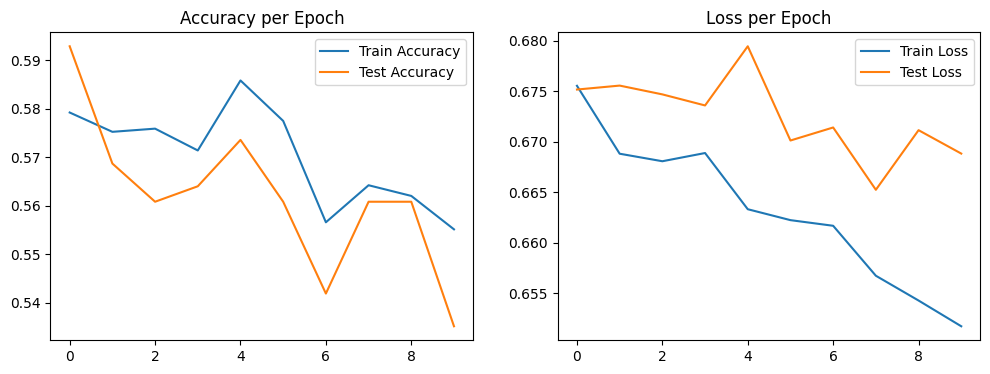

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title("Accuracy per Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss per Epoch")
plt.legend()
plt.show()